In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os 
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from typing import List

# add the path to the sys path
sys.path.append(str(Path().resolve().parent))

from src.utils.plot_utils import process_and_plot_results_multi # process_and_plot_results, 

# define root directory
ROOT_DIR = Path().resolve().parent
data_path = ROOT_DIR / Path('results')

Manual HP Tuning

In [3]:
hps_data_path = data_path / 'HPs' 
metrics = ['mean_reward', 'win_rate'] 
hp_to_plot = ['beta_0', 'eta_0'] 

In [ ]:
hp_data = {}  # {hyperparameter: {metric: {hp_value: [data dataframe]}}}

for hparam in hp_to_plot:
    hp_data_path = hps_data_path / hparam
    if not hp_data_path.exists():
        print(f"Data for model {hparam} does not exist")
        continue

    hp_data[hparam] = {}

    for metric in metrics:
        metric_path = hp_data_path / metric
        if not metric_path.exists():
            print(f"Data for metric {metric} does not exist")
            continue

        hp_data[hparam][metric] = {}

        for filename in os.listdir(metric_path):
            run_path = metric_path / filename
            if not filename.endswith(".csv"):
                continue  # Skip non-CSV files

            try:
                # Extract HP value (last underscore + decimal number)
                hp_str = filename.rsplit("_", 1)[-1].replace(".csv", "")  
                hp_value = float(hp_str[0] + "." + hp_str[1:])
                print(f"hp_value: {hp_value}")
            except ValueError:
                print(f"Skipping file with unexpected name format: {filename}")
                continue

            # Read CSV data
            df = pd.read_csv(run_path)

            # Store data under corresponding HP value
            if hp_value not in hp_data[hparam][metric]:
                hp_data[hparam][metric][hp_value] = []
            hp_data[hparam][metric][hp_value].append(df)


hp_value: 0.6
hp_value: 0.45
hp_value: 0.3
hp_value: 0.15
hp_value: 0.6
hp_value: 0.45
hp_value: 0.3
hp_value: 0.15
hp_value: 0.99
hp_value: 0.992
hp_value: 0.994
hp_value: 0.996
hp_value: 0.99
hp_value: 0.992
hp_value: 0.994
hp_value: 0.996


In [107]:
hp_data['beta_0']['mean_reward'][0.6]

[        Wall time    Step      Value
 0    1.739983e+09   10542 -18.638699
 1    1.739984e+09   23058 -13.805402
 2    1.739984e+09   26082 -12.493675
 3    1.739984e+09   31626 -14.041484
 4    1.739984e+09   45171 -12.493887
 ..            ...     ...        ...
 995  1.740020e+09  998571   6.761761
 996  1.740020e+09  998823   6.763605
 997  1.740020e+09  999096   6.765035
 998  1.740020e+09  999894   6.770561
 999  1.740020e+09  999999   6.771110
 
 [1000 rows x 3 columns]]

n_rows: 2, n_cols: 2
hp_values for beta_0, mean_reward: [0.15, 0.3, 0.45, 0.6]
hp_values for beta_0, win_rate: [0.15, 0.3, 0.45, 0.6]
hp_values for eta_0, mean_reward: [0.99, 0.992, 0.994, 0.996]
hp_values for eta_0, win_rate: [0.99, 0.992, 0.994, 0.996]


C:\Users\flori\AppData\Local\Temp\ipykernel_64160\1484447709.py:194: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=3.0)


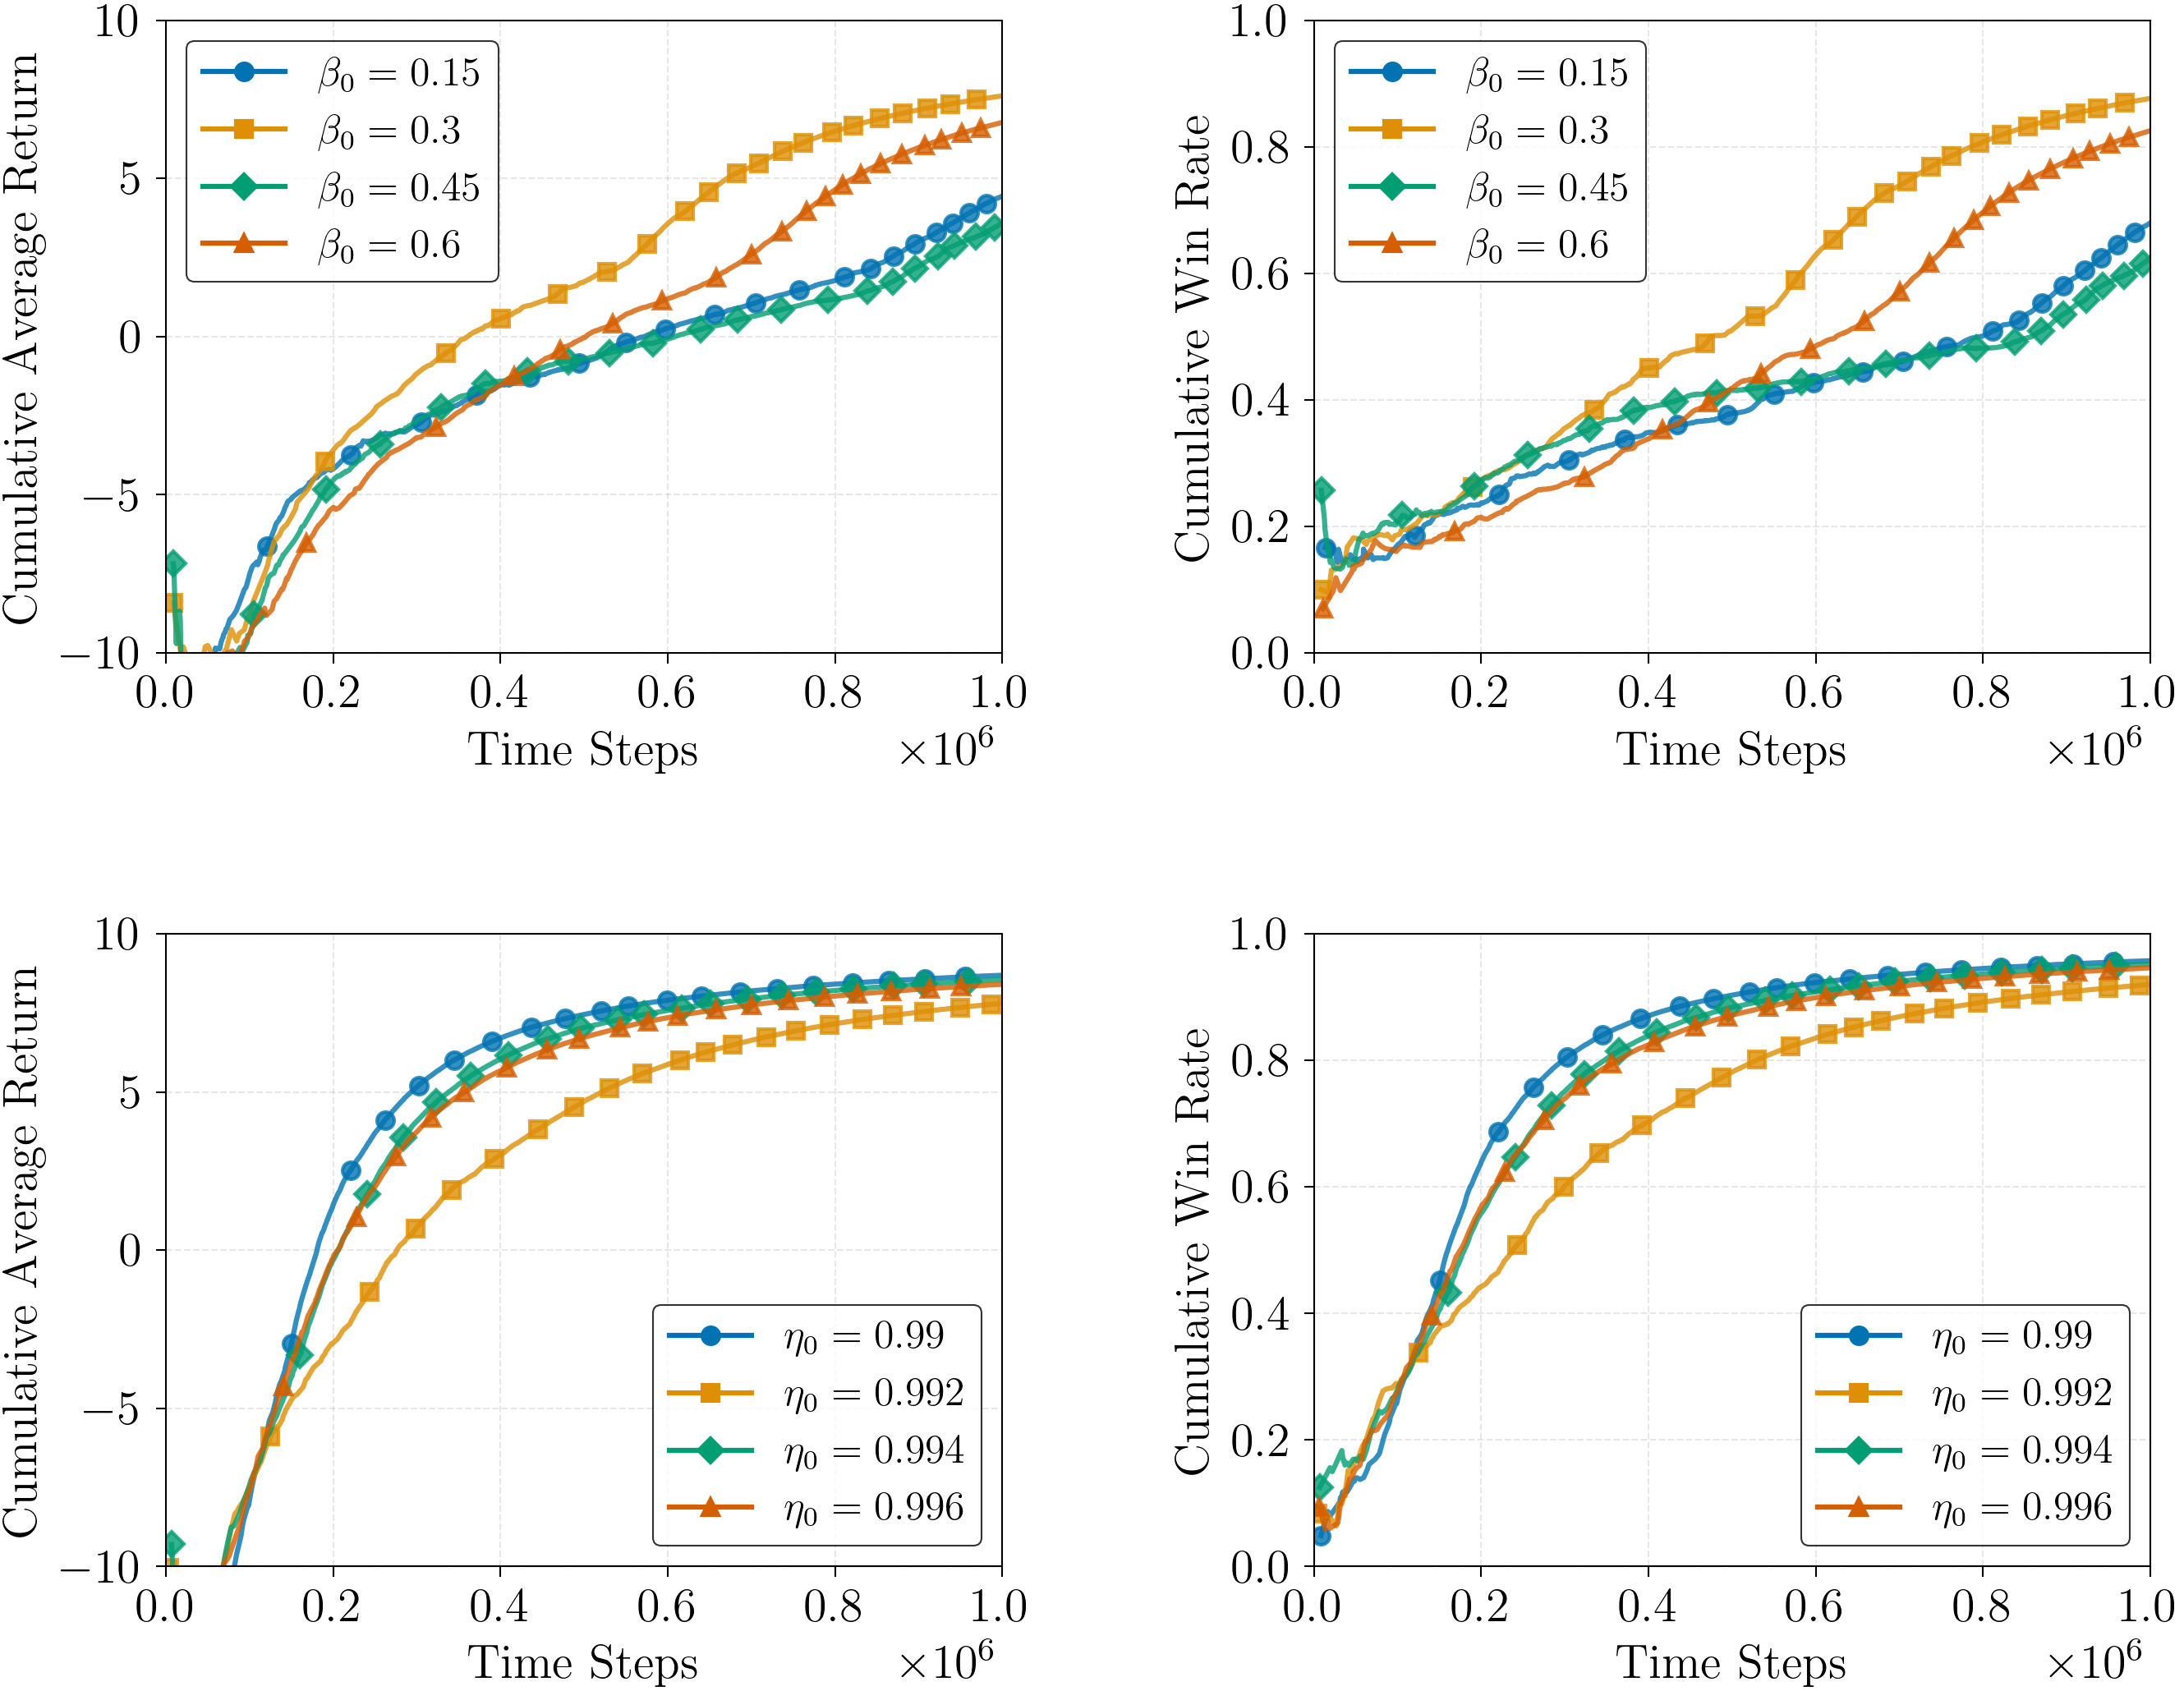

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tueplots import bundles, axes
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
import pandas as pd
import re

def plot_hyperparameter_comparison(
    hp_data: Dict[str, Dict[str, Dict[float, List[Union[np.ndarray, pd.DataFrame]]]]],
    hyperparameters: Optional[List[str]] = None,
    metrics: Optional[List[str]] = None,
    window_size: int = 10000,
    figsize: Tuple[int, int] = None,
    save_path: Optional[Path] = None,
    y_limits: Optional[Dict[str, Tuple[float, float]]] = None,
    log_scale: Optional[Dict[str, bool]] = None,
    max_x_value: Optional[int] = 1000000  # Add parameter to control x-axis limit
):
    """
    Create plots comparing different hyperparameter values for selected metrics.
    
    Args:
        hp_data: Nested dictionary with structure {hyperparameter: {metric: {hp_value: [data for each run]}}}
        hyperparameters: List of hyperparameters to plot (if None, plot all)
        metrics: List of metrics to plot (if None, plot all)
        window_size: Size of the window for smoothing
        figsize: Figure size (automatically calculated if None)
        save_path: Path to save the figure
        y_limits: Dictionary of y-axis limits for each metric {metric: (min, max)}
        log_scale: Dictionary specifying whether to use log scale for each metric {metric: bool}
        max_x_value: Maximum value for x-axis (default: 1,000,000)
    
    Returns:
        matplotlib figure
    """
    # Apply ICML 2022 style
    plt.rcParams.update(bundles.icml2022())
    plt.rcParams.update(axes.lines())
    plt.rcParams.update({
        "figure.dpi": 300,
        'font.size': 14,
        'axes.titlesize': 14,
        'axes.labelsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 12,
        'legend.title_fontsize': 14,
        'text.usetex': True,  # Enable LaTeX rendering
        'text.latex.preamble': r'\usepackage{amsmath}'  # For better math support
    })
    
    # If hyperparameters not specified, use all
    if hyperparameters is None:
        hyperparameters = list(hp_data.keys())
    
    # Determine all metrics if not specified
    all_metrics = set()
    for hp in hyperparameters:
        all_metrics.update(hp_data[hp].keys())
    
    if metrics is None:
        metrics = list(all_metrics)
    
    # Calculate figure dimensions
    n_rows = len(hyperparameters)
    n_cols = len(metrics)
    print(f"n_rows: {n_rows}, n_cols: {n_cols}")
    if figsize is None:
        figsize = (5 * n_cols, 4 * n_rows)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
    
    # Function to convert hyperparameter names to LaTeX format
    def format_hp_name(hp_name):
        # Convert names like 'beta_0' to '\beta_0'
        greek_letters = {
            'beta': r'\beta',
            'eta': r'\eta',
        }
        
        # Check if hp_name starts with any Greek letter name
        for letter_name, latex_symbol in greek_letters.items():
            if hp_name.startswith(letter_name):
                # Replace the Greek letter name with its LaTeX symbol
                hp_name = hp_name.replace(letter_name, latex_symbol, 1)
                break
                
        # Replace underscores with subscripts
        hp_name = hp_name.replace('_', '_{') + '}'.rjust(hp_name.count('_'))
        
        return hp_name
    
    # Process each hyperparameter and metric
    for row_idx, hp in enumerate(hyperparameters):
        for col_idx, metric in enumerate(metrics):
            ax = axs[row_idx, col_idx]
            
            # Skip if this hyperparameter doesn't have data for this metric
            if metric not in hp_data[hp]:
                ax.text(0.5, 0.5, f"No data for\n{metric}", 
                        ha='center', va='center', transform=ax.transAxes)
                continue
            
            # Get all hyperparameter values for this metric
            hp_values = list(hp_data[hp][metric].keys())
            hp_values.sort()  # Sort values for consistent visualization
            print(f"hp_values for {hp}, {metric}: {hp_values}")
            colors = sns.color_palette("colorblind", len(hp_values))
            markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'H', '+', 'x'][:len(hp_values)]
            
            # Set x-axis limit based on max_x_value
            max_steps = max_x_value
            
            # Format the hyperparameter name for LaTeX
            latex_hp = format_hp_name(hp)
            
            # Plot each hyperparameter value
            for i, hp_value in enumerate(hp_values):
                run_data_list = hp_data[hp][metric][hp_value]
                
                # Create a handle for the legend (we'll only add it once)
                legend_handle = None
                
                for j, run_data in enumerate(run_data_list):
                    # Handle both DataFrame and numpy array formats
                    if isinstance(run_data, pd.DataFrame):
                        # Extract steps and values from DataFrame
                        steps = run_data['Step'].values
                        values = run_data['Value'].values
                    else:
                        # Assume it's a numpy array and create evenly spaced steps
                        values = run_data
                        steps = np.arange(0, len(values) * window_size, window_size)
                    
                    # Ensure steps don't exceed max_x_value
                    mask = steps <= max_steps
                    steps = steps[mask]
                    values = values[mask]
                    
                    # Plot with consistent color but varying alpha for multiple runs
                    line = ax.plot(steps, values, 
                            color=colors[i], alpha=0.8, linewidth=1.5,
                            marker=markers[i], markersize=5, markevery=max(1, len(steps)//20),
                            label=None)  # Don't set label here
                    
                    # Save the line for legend if this is the first run
                    if j == 0:
                        legend_handle = line[0]
                
                # Add a single legend entry for this hyperparameter value with LaTeX formatting
                if legend_handle is not None:
                    # Create LaTeX formatted label
                    latex_label = f"${latex_hp} = {hp_value}$"
                    
                    # Create a custom legend entry
                    ax.plot([], [], color=colors[i], marker=markers[i], markersize=5,
                           label=latex_label, linewidth=1.5)
            
            # Set axis labels and limits
            ax.set_xlabel('Time Steps')
            ax.set_xlim(0, max_steps)
            
            # Format y-axis label
            if "mean" in metric.lower():
                ax.set_ylabel("Cumulative Average Return")
            elif "win" in metric.lower():
                ax.set_ylabel("Cumulative Win Rate")
            else:
                ax.set_ylabel(metric.replace('_', ' ').title())
                
            # Apply log scale if specified
            if log_scale and metric in log_scale and log_scale[metric]:
                print(f"Setting log scale for {metric}")
                ax.set_yscale('log')
            
            # Apply y-limits if specified
            if y_limits and metric in y_limits:
                ax.set_ylim(y_limits[metric])
            
            # Add grid and legend
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # Set title to show which hyperparameter and metric with LaTeX formatting
            # latex_metric = metric.replace('_', '\_')  # Escape underscores for LaTeX
            # ax.set_title(f"${latex_hp}$ - {latex_metric}")
            
            # Add a proper legend with no duplicates and LaTeX formatting
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys())
                
    fig.tight_layout(pad=3.0)
    
    if save_path:
        if not str(save_path).endswith('.pdf'):
            save_path = Path(str(save_path) + '.pdf')
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    
    return fig

y_limits = {'mean_reward': (-10, 10), 'win_rate': (0, 1)}
log_scale = {'mean_reward': False, 'win_rate': False}
fig = plot_hyperparameter_comparison(
    hp_data, 
    hyperparameters=['beta_0', 'eta_0'],
    metrics=['mean_reward', 'win_rate'], 
    window_size=10000,
    y_limits=y_limits,
    log_scale=log_scale,
    max_x_value=1000000,  # Set to your actual training length
    # save_path=Path('../plots/beta-eta.pdf')
)

In [ ]:
hp_data['beta_0']['mean_reward'][0.6][0] # hp_data[hyperparameter][metric][hp_value][run_idx], run_idx=0 always only one run per hp

,Wall time,Step,Value
0,1.739983e+09,10542,-18.638699
1,1.739984e+09,23058,-13.805402
2,1.739984e+09,26082,-12.493675
3,1.739984e+09,31626,-14.041484
4,1.739984e+09,45171,-12.493887
...,...,...,...
995,1.740020e+09,998571,6.761761
996,1.740020e+09,998823,6.763605
997,1.740020e+09,999096,6.765035
998,1.740020e+09,999894,6.770561


### Plot Gameplays

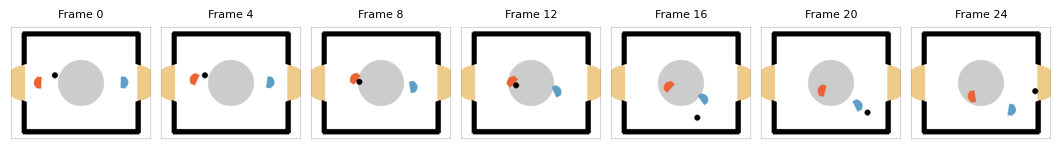

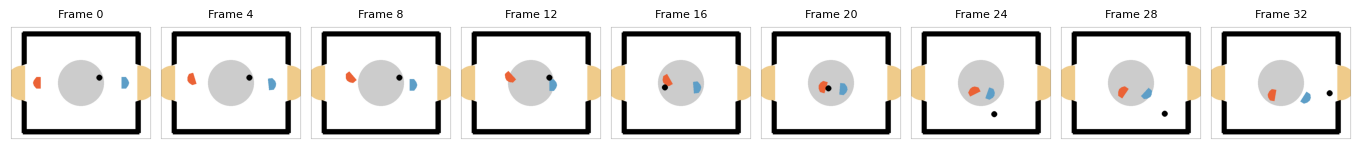

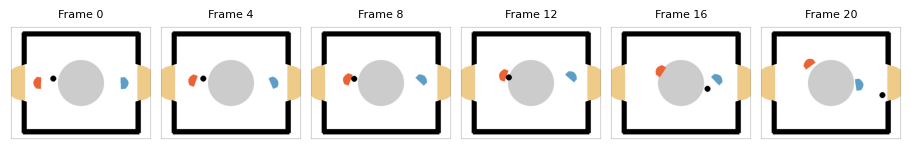

In [32]:
from client.replay_game import plot_game_frames

# Example usage
plot_game_frames("aa209d36-1681-4a7d-9f3a-4417bce15b57", round_id=1, step_size=4, base_path=ROOT_DIR / 'game_data/replays', 
                 save_path=ROOT_DIR / 'plots/game_collage/bank_shot_3.pdf')
plot_game_frames("2ac4fa98-0181-4900-b41a-b05f0a4c6d13", round_id=0, step_size=4, base_path=ROOT_DIR / 'game_data/replays', 
                save_path=ROOT_DIR / 'plots/game_collage/blocking_bank_shot_3.pdf')
plot_game_frames("0326cf98-ccce-4b63-af7a-233c44c6497f", round_id=3, step_size=4, base_path=ROOT_DIR / 'game_data/replays', 
                 save_path=ROOT_DIR / 'plots/game_collage/snipe_shot_3.pdf')



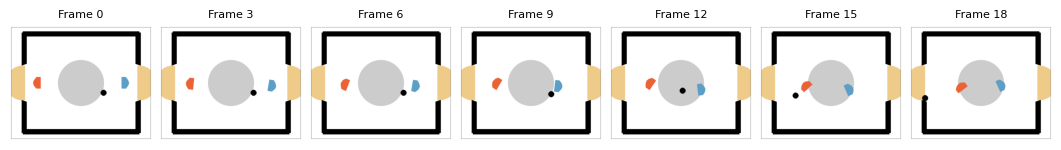

In [ ]:
# failure modes
plot_game_frames("364aec4e-cb04-4ac5-8227-9b020d0f3b36", round_id=0, step_size=3, base_path=ROOT_DIR / 'game_data/replays', 
)#save_path=ROOT_DIR / 'plots/game_collage/failure_mode_1.pdf')

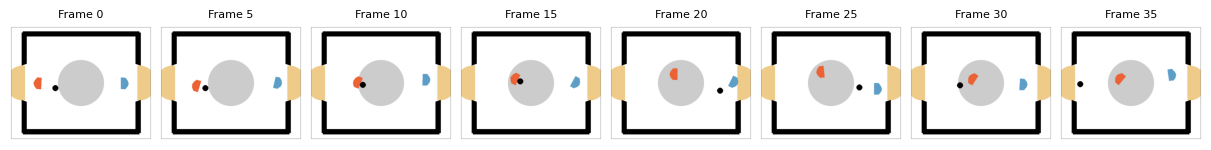

In [38]:
plot_game_frames("8b159818-f713-4299-967e-d29083742104", round_id=1, step_size=5, base_path=ROOT_DIR / 'game_data/replays', 
)#save_path=ROOT_DIR / 'plots/game_collage/failure_mode_1.pdf')

### SAC Ablation Studies

In [143]:
model_modifications = ['sac_default', 'sac_ere', 'sac_ere_per']
metrics = ['mean_reward', 'win_rate'] # Corresponds to mean cumulative reward and win rate over n=10 episodes training against weak opponent

In [144]:
model_modification_data = {} # {model_modification: {metric: [data for each run]}}

for model_modification in model_modifications:
    model_data_path = data_path / model_modification
    if not model_data_path.exists():
        print('Data for model {} does not exist'.format(model_modification))
        continue
    model_modification_data[model_modification] = {}
    for metric in metrics:
        metric_data = []
        metric_path = model_data_path / metric
        if not metric_path.exists():
            print('Data for metric {} does not exist'.format(metric))
            continue
        for run in os.listdir(metric_path):
            run_path = metric_path / run
            # metric_file = run_path / (metric + '.csv')
            metric_data.append(pd.read_csv(run_path))
        model_modification_data[model_modification][metric] = metric_data

In [145]:
from tueplots import bundles
bundles.icml2022()
from tueplots import axes
axes.lines()
plt.rcParams.update(axes.lines())
plt.rcParams.update({"figure.dpi": 150})

C:\Machine Learning\Master Tuebingen\Semester_3\RL\hockey-rl-challenge\src\utils\plot_utils.py:139: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=3.0)


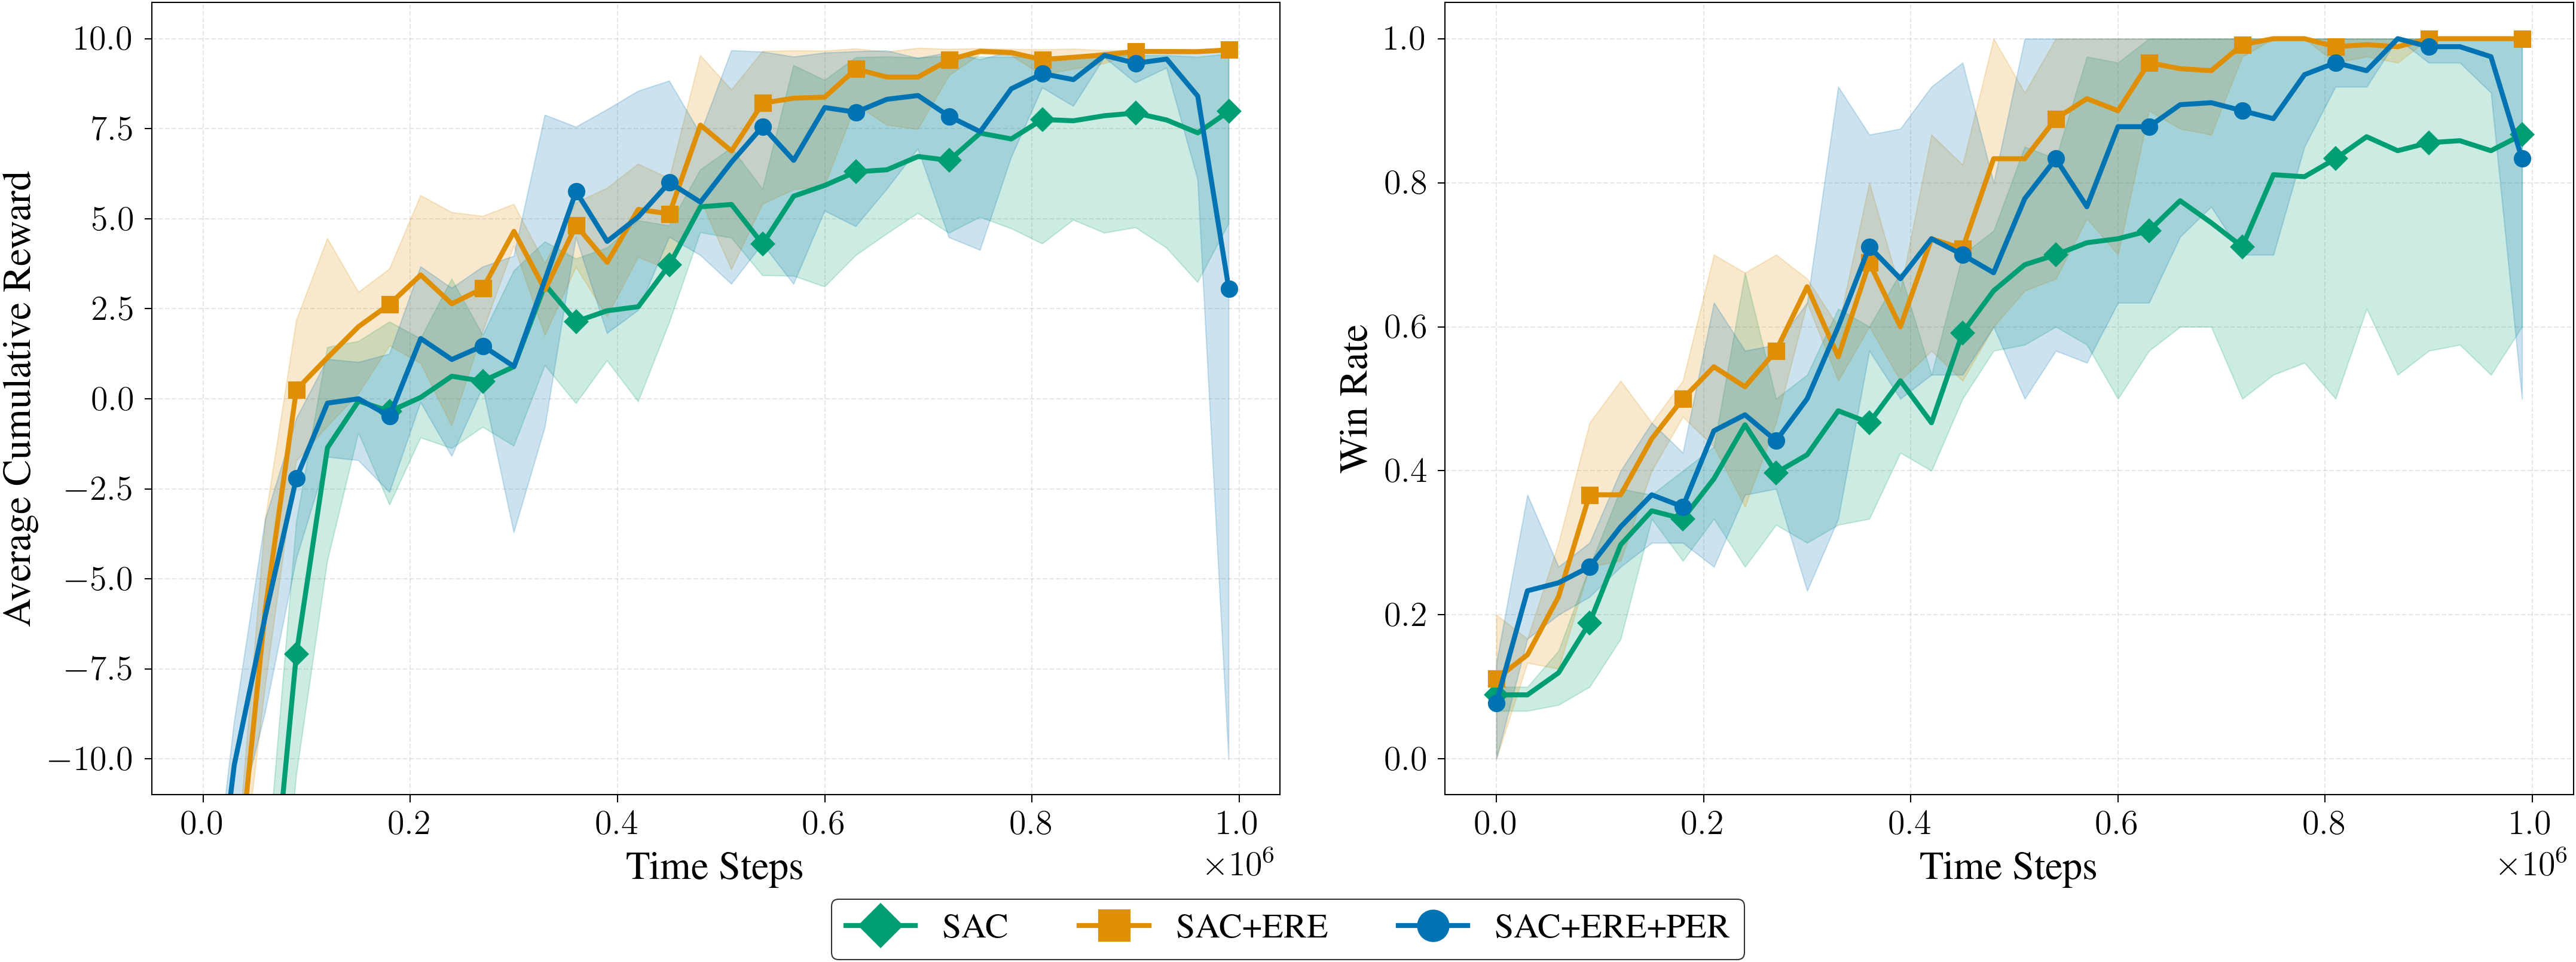

In [146]:
data_configs = [
    {
        'model_dataframes': {
            'SAC': model_modification_data['sac_default']['mean_reward'],
            'SAC+ERE': model_modification_data['sac_ere']['mean_reward'],
            'SAC+ERE+PER': model_modification_data['sac_ere_per']['mean_reward']
        },
        'yaxis_label': 'Average Cumulative Reward',
        # 'title': 'Reward'
        'use_log_scale': False,
        'y_limits': (-11,11)
    },
    {
        'model_dataframes': {
            'SAC': model_modification_data['sac_default']['win_rate'],
            'SAC+ERE': model_modification_data['sac_ere']['win_rate'],
            'SAC+ERE+PER': model_modification_data['sac_ere_per']['win_rate']
        },
        'yaxis_label': 'Win Rate',
        # 'title': 'Win Rate'
    }
]

fig = process_and_plot_results_multi(data_configs, window_size=30000,save_path=ROOT_DIR / 'plots' / 'sac_ere_per_train_comparison_final_4')
plt.show()

C:\Machine Learning\Master Tuebingen\Semester_3\RL\hockey-rl-challenge\src\utils\plot_utils.py:132: UserWarning: The figure layout has changed to tight
  plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)


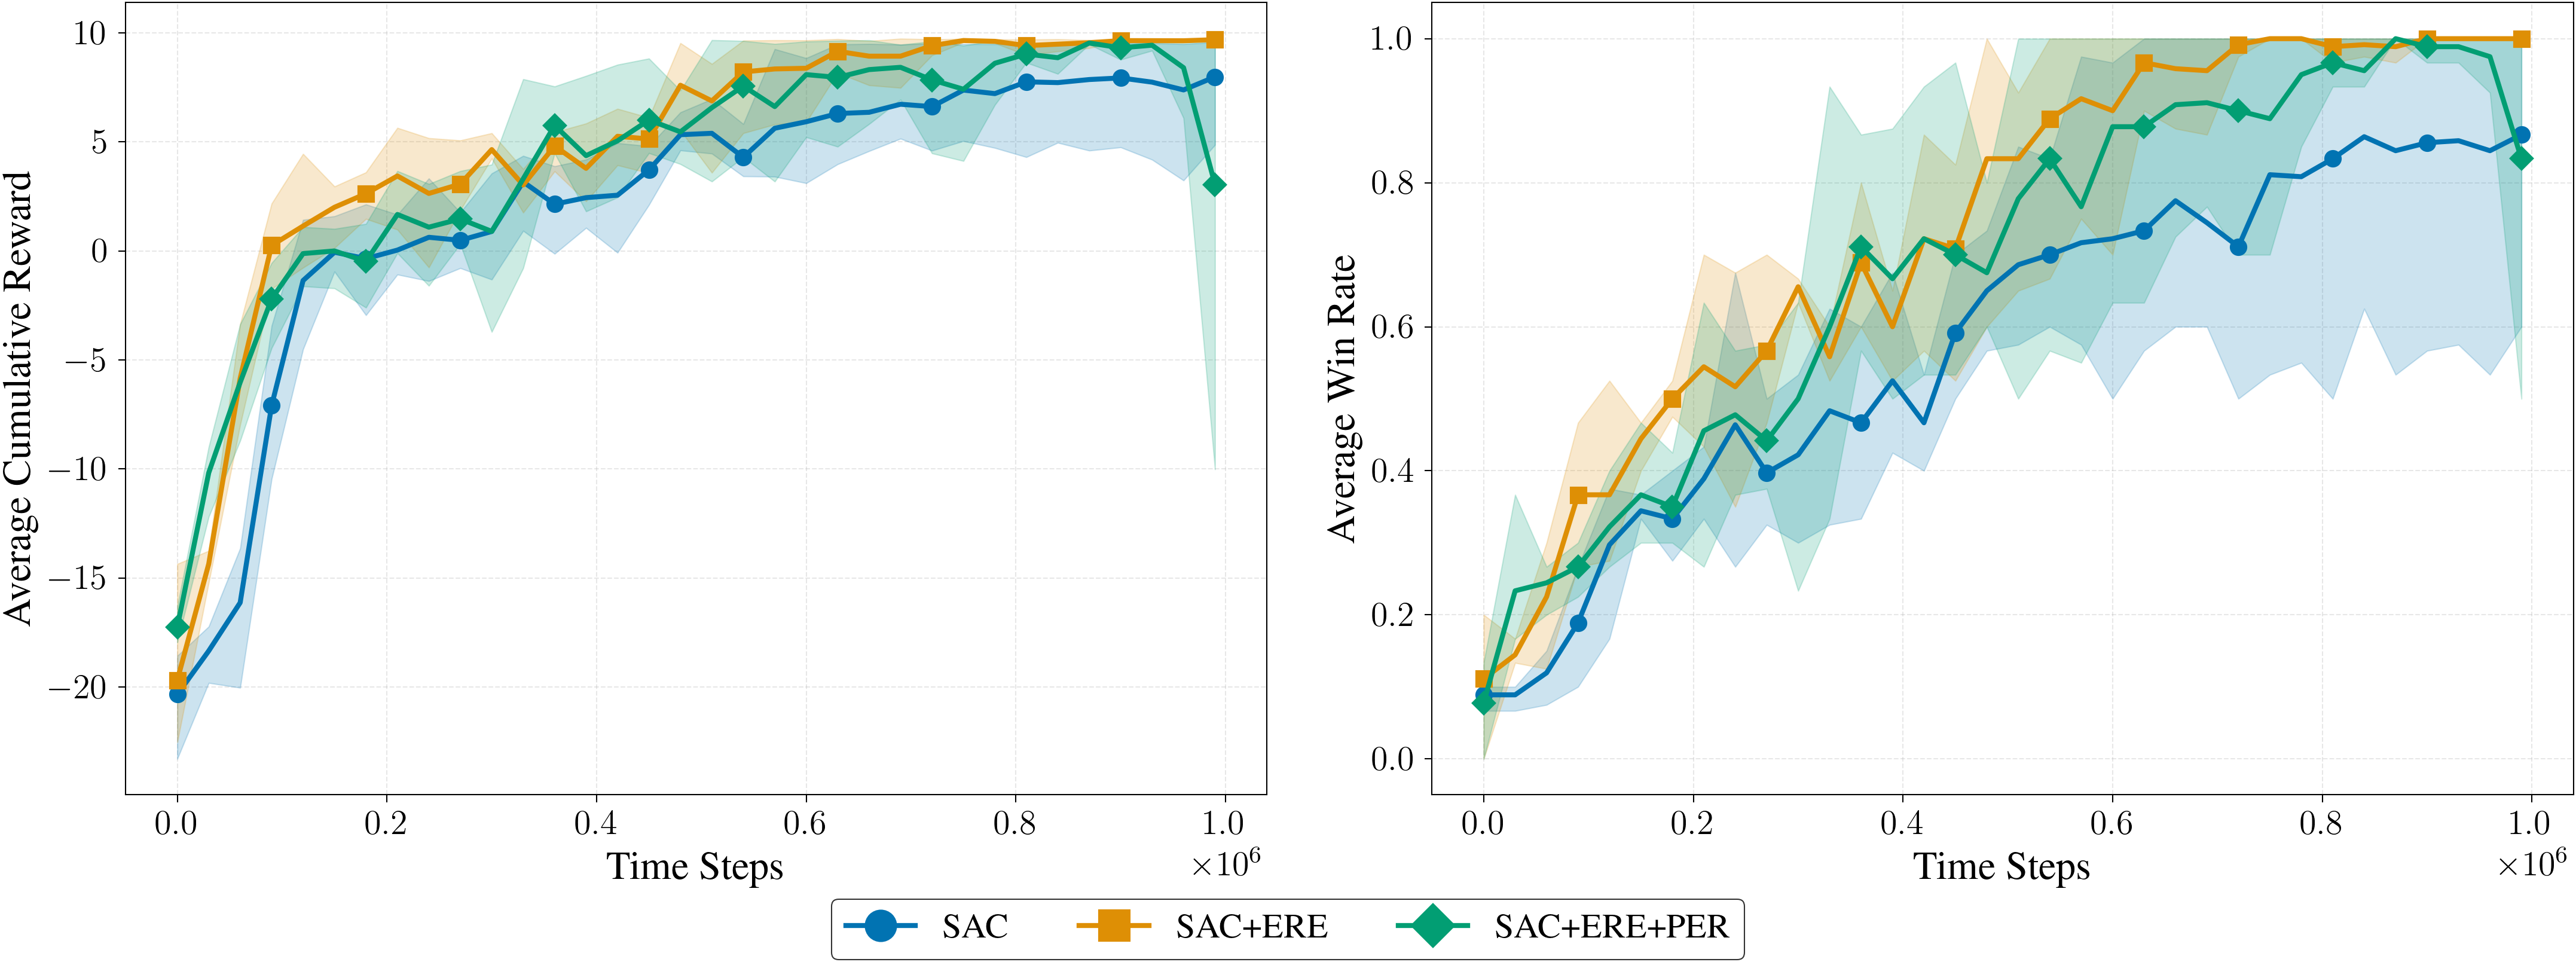

In [86]:
fig = process_and_plot_results_multi(data_configs, window_size=30000, save_path=ROOT_DIR / 'plots' / 'sac_ere_per_train_comparison_final_2')
plt.show()

### Evaluate Agents

In [31]:
import argparse
import ast
import datetime
import json
import os
import time
from glob import glob

import imageio
import numpy as np
from PIL import Image
import pickle


from hockey.hockey_env import CENTER_X, CENTER_Y, FPS, HockeyEnv



In [32]:
games_path = ROOT_DIR / 'game_data'
id = None
record=True
render = True
output_path = ROOT_DIR / 'game_data/replays'
verbose= True


In [ ]:
env = HockeyEnv()
# print absolute path of games_path
games_path = os.path.abspath(games_path)
print(f"games_path: {games_path}")

matches = []
for match_path in glob(os.path.join(games_path, "**", "*.pkl"), recursive=True):
    with open(match_path, "rb") as f:
        match_data = pickle.load(f)

    # Extract identifier from filename (everything before ".pkl")
    identifier = os.path.splitext(os.path.basename(match_path))[0]
    match_data["identifier"] = identifier  # Add identifier to the dictionary

    matches.append(match_data)

if id is not None:
    matches = [match for match in matches if match["identifier"] == id]

if record:
    video, video_path = setup_video(output_path, match["identifier"], FPS)


games_path: C:\Machine Learning\Master Tuebingen\Semester_3\RL\hockey-rl-challenge\game_data


In [48]:
matches[0].keys()

dict_keys(['actions_round_0', 'observations_round_0', 'actions_round_1', 'observations_round_1', 'actions_round_2', 'observations_round_2', 'actions_round_3', 'observations_round_3', 'num_rounds', 'actions', 'identifier'])

In [47]:
matches[0]['num_rounds'][0].item()

4